In [4]:
%matplotlib inline
import requests
import csv
import pytz
import time
from datetime import datetime, timedelta
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [5]:
start = datetime(2008, 3, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 = '198.41.0.4' 
prefix6 = '2001:503:BA3E::2:30'

In [6]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_state = []
    if data:
        for item in data:
            route_info = {
                'peer': item['path'][0],
                'root': item['path'][-1],
                'as_path': list(deduplicate(item['path']))
            }
            bgp_state.append(route_info)

    peer = [item['peer'] for item in bgp_state]

    return bgp_state, peer

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

In [7]:
utc = pytz.utc
with open('a-root-mutual-as-path-stats.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=',')
    # csv header first
    writer.writerow(['time', 'identical', 'diff', 'v4_longer', 'v4_shorter'])
    cur_date = start
    while cur_date <= stop:
        print(cur_date)
        
        utc_dt = utc.localize(cur_date)
        timestamp = int(time.mktime(utc_dt.timetuple()))
        
        bgp_state4, peer4 = get_peers(prefix4, timestamp)
        bgp_state6, peer6 = get_peers(prefix6, timestamp)
        
        mutual_peers = list(set(peer4) & set(peer6))
        
        mutual_peers_stat = get_peers_stat(mutual_peers, bgp_state4, bgp_state6)
        
        time_str = cur_date.strftime('%Y-%m-%d')
        result_all = len([i['peer'] for i in mutual_peers_stat])
        result_identical = len([i['peer'] for i in mutual_peers_stat if i['similar'] == 1])
        result_diff = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) == len(i['path6']) and i['similar'] == 0])
        result_v4_longer = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) > len(i['path6'])])
        result_v4_shorter = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) < len(i['path6'])])
        
        writer.writerow((time_str, result_identical, result_diff, result_v4_longer, result_v4_shorter))
        
        year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
        month = 1 if cur_date.month == 12 else cur_date.month + 1
        cur_date = datetime(year, month, 1, 1, 0, 0)
    
    

2008-03-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=198.41.0.4&timestamp=1204329600
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:503:BA3E::2:30&timestamp=1204329600
2008-04-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=198.41.0.4&timestamp=1207008000
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:503:BA3E::2:30&timestamp=1207008000
2008-05-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=198.41.0.4&timestamp=1209600000
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:503:BA3E::2:30&timestamp=1209600000
2008-06-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=198.41.0.4&timestamp=1212278400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:503:BA3E::2:30&timestamp=1212278400
2008-07-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=198.41.0.4&tim

In [8]:
df = pd.read_csv('a-root-mutual-as-path-stats.csv', index_col=0)
df

,identical,diff,v4_longer,v4_shorter
time,,,,
2008-03-01,0,0,23,0
2008-04-01,0,0,0,0
2008-05-01,0,0,1,0
2008-06-01,0,0,0,0
2008-07-01,0,0,3,0
2008-08-01,0,0,0,0
2008-09-01,0,0,0,0
2008-10-01,0,0,0,0
2008-11-01,0,0,0,0


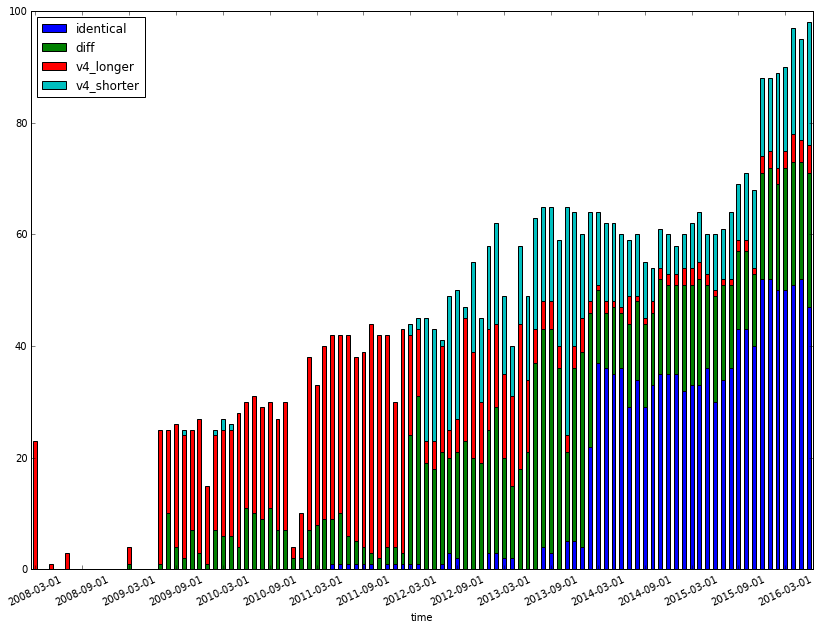

In [11]:
plot = df.plot.bar(stacked=True, figsize=(14,10))

n = 6

ticks = plot.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in plot.xaxis.get_ticklabels()]
plot.xaxis.set_ticks(ticks[::n])
plot.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

# RQ: How different is IPv4 and IPv6 catchment areas?

## RQ.1 IPv4/IPv6 peer degree distribution?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

timestamp = 1464739200 # 2013-06-01
# url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
prefix4 = '198.41.0.4' 
prefix6 = '2001:503:BA3E::2:30'

Find out the mutual peers

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers

data4, peer4 = get_peers(prefix4, timestamp)
data6, peer6 = get_peers(prefix6, timestamp)

mutual_peers = list(set(peer4) & set(peer6))

get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=198.41.0.4&timestamp=1464739200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:503:BA3E::2:30&timestamp=1464739200


then, find mutual peers with different path

In [3]:
mutual_peers_diff = {}

for peer in mutual_peers:
    if data4[peer]['path'] != data6[peer]['path']:
        mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}

data processing

In [4]:
from pandas import DataFrame

processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')
for index, row in processed_data.iterrows():
    processed_data.set_value(index, 'len4', len(row['path4']))
    processed_data.set_value(index, 'len6', len(row['path6']))
processed_data

,path4,path6,collector,len4,len6
286,"[286, 7342, 36625]","[286, 702, 7342, 36625]","LINX, London",3.0,4.0
513,"[513, 21320, 2603, 7342, 36625]","[513, 21320, 6939, 7342, 36622]","CIXP, Geneva",5.0,5.0
1836,"[1836, 7342, 36625]","[1836, 6939, 7342, 36622]","SwissIX, Zurich",3.0,4.0
1853,"[1853, 1764, 7342, 36622]","[1853, 6939, 7342, 36622]","VIX, Vienna",4.0,4.0
3257,"[3257, 7342, 36625]","[3257, 3491, 36631]","Frankfurt, Germany",3.0,3.0
3491,"[3491, 2914, 36625]","[3491, 36631]","NAP Africa JB, Johannesburg",3.0,2.0
4589,"[4589, 7342, 36622]","[4589, 7342, 36619]","Frankfurt, Germany",3.0,3.0
5396,"[5396, 3257, 7342, 36625]","[5396, 6939, 7342, 36622]","Milan, Italy",4.0,4.0
6453,"[6453, 7342, 36625]","[6453, 7342, 36619]","AMS-IX and NL-IX, Amsterdam",3.0,3.0
6720,"[6720, 8447, 7342, 36625]","[6720, 1853, 6939, 7342, 36622]","VIX, Vienna",4.0,5.0


### Plot

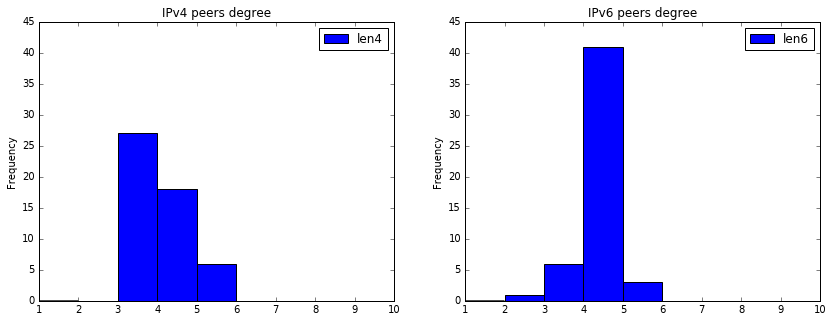

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2)

processed_data[['len4']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[0], ylim=(0,45), title='IPv4 peers degree')
processed_data[['len6']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[1], ylim=(0,45), title='IPv6 peers degree')

plt.show()

## RQ.2 AS path average length?

In [10]:
avg4 = processed_data['len4'].mean()
avg6 = processed_data['len6'].mean()

print('IPv4 average path length: {}'.format(avg4))
print('IPv6 average path length: {}'.format(avg6))

IPv4 average path length: 3.588235294117647
IPv6 average path length: 3.9019607843137254


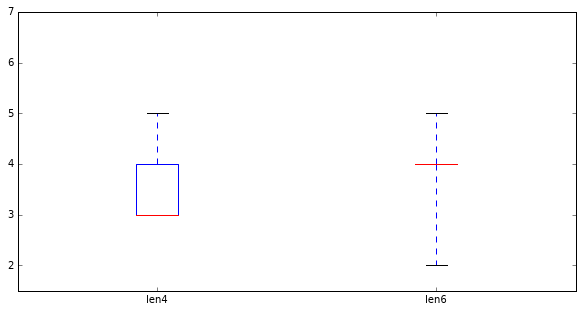

In [11]:
processed_data[['len4', 'len6']].plot.box(figsize=(10,5), ylim=(1.5,7))
plt.show()

## RQ.3 ASes most frequently seen?

### IPv4

In [13]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

res = []

for item in processed_data['path4']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv4 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 


Most frequently seen ASes in IPv4 AS paths:
7342	41
2914	5
3356	4
13030	3
29075	2
12956	2
3257	2
10429	2
4635	1
21320	1
12874	1
174	1
15576	1
6939	1
24611	1
1764	1
3303	1
8220	1
6762	1
2603	1
1836	1
30781	1
12989	1
31025	1
12586	1
29691	1
1916	1
8447	1


Most frequently seen per degree (degree is as seen from Root ASN)

In [14]:
max = processed_data['len4'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path4']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	7342	41
	2914	5
	3356	4
	4635	1
(*) Hop 2:
	13030	4
	3257	3
	29075	2
	12956	2
	1836	2
	47872	1
	49835	1
	37271	1
	6762	1
	25160	1
	1916	1
	12874	1
	9002	1
	31122	1
	8596	1
	198290	1
	7575	1
	9304	1
	56730	1
	6939	1
	8220	1
	34781	1
	286	1
	24611	1
	3491	1
	1764	1
	62567	1
	29608	1
	50300	1
	8426	1
	2603	1
	4589	1
	174	1
	30781	1
	31025	1
	3303	1
	6453	1
	49463	1
	14840	1
	15547	1
	30844	1
	12989	1
	8447	1
(*) Hop 3:
	29691	2
	10429	2
	6720	1
	25152	1
	20612	1
	198249	1
	21320	1
	51405	1
	52888	1
	5396	1
	41497	1
	15576	1
	58308	1
	34146	1
	28329	1
	12586	1
	1853	1
	15605	1
	8758	1
	59689	1
	22548	1
	50620	1
(*) Hop 4:
	513	1
	53070	1
	262317	1
	196621	1
	57118	1
	57821	1


### IPv6

In [16]:
res = []

for item in processed_data['path6']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv6 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 

Most frequently seen ASes in IPv6 AS paths:
7342	48
6939	40
3491	2
15576	1
702	1
3303	1
21320	1
12874	1
23148	1
1853	1


most frequently seen ASes per degree

In [17]:
max = processed_data['len6'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path6']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	7342	48
	3491	3
(*) Hop 2:
	6939	40
	30844	1
	12874	1
	6453	1
	13030	1
	3303	1
	3257	1
	9002	1
	23148	1
	4589	1
	702	1
(*) Hop 3:
	1853	2
	25152	1
	47872	1
	57118	1
	20612	1
	198249	1
	25160	1
	37271	1
	59689	1
	51405	1
	53070	1
	262317	1
	52888	1
	31122	1
	22548	1
	198290	1
	7575	1
	9304	1
	41497	1
	56730	1
	8596	1
	58308	1
	34781	1
	286	1
	34146	1
	15547	1
	62567	1
	29608	1
	28329	1
	8426	1
	49835	1
	1836	1
	15576	1
	57821	1
	21320	1
	15605	1
	8758	1
	49463	1
	14840	1
	5396	1
	29691	1
	50300	1
	50620	1
(*) Hop 4:
	6720	1
	513	1
	196621	1


## RQ.4 For shorter IPv6 path, which ASes frequently appear as transit?

In [18]:
temp= []
for item in processed_data.iterrows():
    if item[1]['len4'] > item[1]['len6']:
        for asn in item[1]['path6'][1:-1]:
            temp.append(asn)

print(temp)
results = most_common(temp)
for result in results:
    print('{}\t{}'.format(result[0], result[1]))

[6939, 7342, 6939, 7342, 6939, 7342, 6939, 7342]
6939	4
7342	4


## RQ.5 For peers with same IPv4/IPv6 path length but different path, how different is it?
calculate the percentage of different AS hop, and find out which ASes are frequently appear in the IPv6 path

In [22]:
temp = []

print('-----------------------------------------------------------------')
print('Including the originating AS (A-Root uses multiple origin ASes)')
print('------------------------------------------------------------------')

result = {}
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4']) 
        for i in range(0, path_length):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))
    
    
print('-----------------------------------------------------------------')
print('Excluding the originating AS (A-Root uses multiple origin ASes)')
print('------------------------------------------------------------------')
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4']) 
        for i in range(0, path_length - 1):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))

-----------------------------------------------------------------
Including the originating AS (A-Root uses multiple origin ASes)
------------------------------------------------------------------
Peer 513: 	length:5 	difference: 40.0%
Peer 1853: 	length:4 	difference: 25.0%
Peer 3257: 	length:3 	difference: 66.66666666666666%
Peer 4589: 	length:3 	difference: 33.33333333333333%
Peer 5396: 	length:4 	difference: 50.0%
Peer 6453: 	length:3 	difference: 33.33333333333333%
Peer 8758: 	length:4 	difference: 25.0%
Peer 9002: 	length:3 	difference: 33.33333333333333%
Peer 13030: 	length:3 	difference: 33.33333333333333%
Peer 15605: 	length:4 	difference: 25.0%
Peer 20612: 	length:4 	difference: 50.0%
Peer 22548: 	length:4 	difference: 25.0%
Peer 25152: 	length:4 	difference: 25.0%
Peer 28329: 	length:4 	difference: 50.0%
Peer 29691: 	length:4 	difference: 25.0%
Peer 30844: 	length:3 	difference: 66.66666666666666%
Peer 34146: 	length:4 	difference: 50.0%
Peer 41497: 	length:4 	difference: 50

## RQ.6 Can we correlate the path difference to their physical location? (based on the location of RIS collector)?

In [23]:
peer_location = processed_data.groupby('collector')
peer_location['collector'].count().sort_values(ascending=False)

collector
SwissIX, Zurich                9
France-IX, Paris               9
Sao Paulo, Brazil              6
VIX, Vienna                    3
RIPE NCC, Amsterdam            3
New York (NY), USA             3
NAP Africa JB, Johannesburg    3
Milan, Italy                   3
LINX, London                   3
Frankfurt, Germany             2
CATNIX, Barcelona              1
CIXP, Geneva                   1
Moscow, Russia                 1
Miami, USA                     1
Palo Alto, USA                 1
Stockholm, Sweden              1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv6 path?

In [24]:
v6_shorter = processed_data[processed_data.len4 > processed_data.len6].groupby('collector')
v6_shorter['collector'].count().sort_values(ascending=False)

collector
Sao Paulo, Brazil              2
SwissIX, Zurich                1
RIPE NCC, Amsterdam            1
NAP Africa JB, Johannesburg    1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv4 path?

In [25]:
v4_shorter = processed_data[processed_data.len4 < processed_data.len6].groupby('collector')
v4_shorter['collector'].count().sort_values(ascending=False)

collector
France-IX, Paris               5
LINX, London                   3
VIX, Vienna                    2
SwissIX, Zurich                2
RIPE NCC, Amsterdam            2
New York (NY), USA             2
Stockholm, Sweden              1
Sao Paulo, Brazil              1
Palo Alto, USA                 1
NAP Africa JB, Johannesburg    1
CATNIX, Barcelona              1
Name: collector, dtype: int64

# RQ: How do IPv4 and IPv6 catchment areas evolve over time?
Note that here we only use mutual peers that have different IPv4/IPv6 path

## RQ.1 IPv4/IPv6 peer degree distribution over time?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from datetime import datetime
import pytz
import time
import csv
from pandas import DataFrame

utc = pytz.utc

start = datetime(2008, 3, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 = '198.41.0.4' 
prefix6 = '2001:503:BA3E::2:30'

csv_dir = 'datasets/a/'

*helper methods*

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers


def get_mutual_peer_with_diff_paths(timestamp):
    """
    get mutual peer with different IPv4/IPv6 paths
    """
    data4, peer4 = get_peers(prefix4, timestamp)
    data6, peer6 = get_peers(prefix6, timestamp)

    mutual_peers = list(set(peer4) & set(peer6))

    mutual_peers_diff = {}

    for peer in mutual_peers:
        if data4[peer]['path'] != data6[peer]['path']:
            mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}
    
    return mutual_peers_diff

## Get data, write to .csv file
Do it only once!!!

In [29]:
result = {}
cur_date = start
print('start.....')
while cur_date <= stop:
    # do something here
    utc_dt = utc.localize(cur_date)
    timestamp = int(time.mktime(utc_dt.timetuple()))
    
    mutual_peers_diff = get_mutual_peer_with_diff_paths(timestamp)

    processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

    for index, row in processed_data.iterrows():
        processed_data.set_value(index, 'len4', len(row['path4']))
        processed_data.set_value(index, 'len6', len(row['path6']))
    
    path_file = '{}{}-path.csv'.format(csv_dir, timestamp)
    processed_data.to_csv(path_file, sep='\t')
    
    # increment cur_date
    year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
    month = 1 if cur_date.month == 12 else cur_date.month + 1
    cur_date = datetime(year, month, 1, 1, 0, 0)

print('stop...')

start.....
stop...


### Data Analysis
get peer's degree for both IPv4 and IPv6

In [3]:
import os

In [4]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4'].value_counts()
        result4[timestamp] = res4
        res6 = opened_file['len6'].value_counts()
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()
print('finish.')

finish.


### Plot

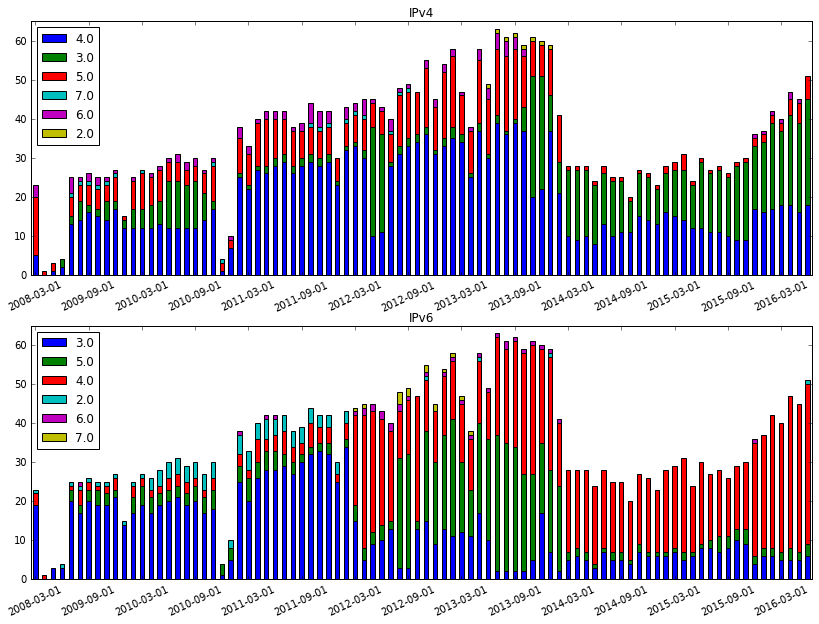

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1)

plot_result4 = DataFrame.from_dict(result4, orient='index')
plot_result6 = DataFrame.from_dict(result6, orient='index')

plot4 = plot_result4.plot.bar(stacked=True, ax=axes[0], figsize=(14,10), ylim=(0,65), title='IPv4')
plot6 = plot_result6.plot.bar(stacked=True, ax=axes[1], figsize=(14,10), ylim=(0,65),title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.2 AS path average length?

/home/arif/Github/Thesis-Code/env/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


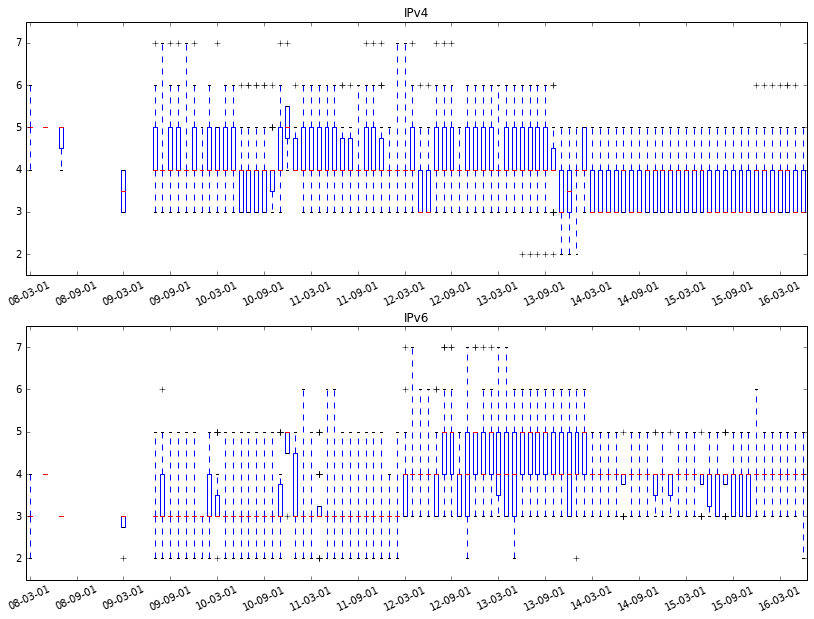

In [16]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4']
        res6 = opened_file['len6']
        result4[timestamp] = res4
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()

plot_result4 = DataFrame.from_dict(result4)
plot_result6 = DataFrame.from_dict(result6)


################
# Plot
################
fig, axes = plt.subplots(nrows=2, ncols=1)

plot4 = plot_result4.plot.box(figsize=(14,10), ax=axes[0], ylim=(1.5,7.5), title='IPv4')
plot6 = plot_result6.plot.box(figsize=(14,10), ax=axes[1], ylim=(1.5,7.5), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.3 Most frequently seen ASes on the path?

### IPv4

In [7]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path4']:
            # transform string of AS path into python's list
            path4 = item[1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            # exclude origin AS and probe AS
            for i in path4[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv4 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv4 AS paths (2008-03-01):
26134	23
10913	13
1239	5
3549	4
7018	3
1299	3
3356	3
2914	2
22773	2
3320	2

[*] Most frequently seen ASes in IPv4 AS paths (2008-05-01):
1299	1
26134	1
1239	1

[*] Most frequently seen ASes in IPv4 AS paths (2008-07-01):
26134	3
10913	2
22212	2
7018	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-03-01):
36620	4
3356	2

[*] Most frequently seen ASes in IPv4 AS paths (2009-07-01):
36620	25
3356	18
6453	4
2914	2
3257	1
20965	1
3303	1
34215	1
174	1
1103	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-08-01):
36619	25
3549	11
3257	3
3356	3
6453	2
2914	1
20965	1
3303	1
25512	1
174	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-09-01):
36620	26
3549	12
3356	8
6453	4
2914	1
15685	1
3303	1
34215	1
1103	1
5392	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-10-01):
36620	25
3549	11
3356	8
6453	4
2914	1
15685	1
3303	1
34215	1
1103	1
5392	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-11-01):
3

### IPv6

In [8]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path6']:
            # transform string of AS path into python's list
            path6 = item[1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            # exclude origin AS and probe AS
            for i in path6[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv6 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv6 AS paths (2008-03-01):
6939	12
3257	6
3356	4
5602	1
41692	1
20965	1

[*] Most frequently seen ASes in IPv6 AS paths (2008-05-01):
3257	1
41692	1

[*] Most frequently seen ASes in IPv6 AS paths (2008-07-01):
6939	2
3257	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-03-01):
6939	3

[*] Most frequently seen ASes in IPv6 AS paths (2009-07-01):
6939	19
3356	3
1125	1
1299	1
1103	1
20965	1
30071	1
29208	1
7018	1
6175	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-08-01):
6939	17
6175	7
3549	2
2914	1
20965	1
1103	1
1125	1
6453	1
29208	1
3257	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-09-01):
6939	19
6175	6
1125	1
12779	1
20965	1
15685	1
29208	1
1103	1
3356	1
3549	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-10-01):
6939	17
7018	3
30071	2
3356	2
20965	1
15685	1
1103	1
1125	1
1299	1
6453	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-11-01):
6939	17
7018	3
3356	2
20965	1
15685	1
1103	1
1125	1
1299	1
6453	1

## RQ.4a For shorter IPv6 path, which ASes frequently appear as transit?

In [9]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] > item[1]['len6']:
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            for asn in path6[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2008-03-01:
	6939	12
	3257	6
	3356	4
	5602	1
	41692	1
[*] at 2008-04-01:
[*] at 2008-05-01:
	3257	1
	41692	1
[*] at 2008-06-01:
[*] at 2008-07-01:
	6939	2
	3257	1
[*] at 2008-08-01:
[*] at 2008-09-01:
[*] at 2008-10-01:
[*] at 2008-11-01:
[*] at 2008-12-01:
[*] at 2009-01-01:
[*] at 2009-02-01:
[*] at 2009-03-01:
	6939	2
[*] at 2009-04-01:
[*] at 2009-05-01:
[*] at 2009-06-01:
[*] at 2009-07-01:
	6939	18
	3356	3
	1125	1
	1299	1
	1103	1
[*] at 2009-08-01:
	6939	12
	6175	2
	2914	1
[*] at 2009-09-01:
	6939	18
	6175	3
	1125	1
	29208	1
	1103	1
[*] at 2009-10-01:
	6939	16
	3356	2
	6453	1
	1103	1
	15685	1
[*] at 2009-11-01:
	6939	13
	3356	2
	1103	1
	6453	1
	30071	1
[*] at 2009-12-01:
	6939	16
	3356	3
	6175	2
	6453	1
	15685	1
[*] at 2010-01-01:
	6939	11
	3356	1
	6175	1
[*] at 2010-02-01:
	6939	12
	3356	3
	1125	1
	30071	1
	6730	1
[*] at 2010-03-01:
	6939	15
	3356	2
	1125	1
	30071	1
	6730	1
[*] at 2010-04-01:
	6939	13
	3356	2
	1125	1
	30071	1
	7018	1
[*] at 2010-05-01:
	6939	16
	3356	3
	1

## RQ.4b For shorter IPv6 path, how different is it?

In [11]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) > len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path4) - len(path6), (len(path4) - len(path6)) / len(path4) * 100))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
286	5	3	2	40.00%
559	5	3	2	40.00%
1103	5	3	2	40.00%
1280	5	3	2	40.00%
1853	5	3	2	40.00%
1930	6	4	2	33.33%
2497	4	3	1	25.00%
2914	4	3	1	25.00%
3257	5	2	3	60.00%
4589	5	3	2	40.00%
6667	4	3	1	25.00%
6762	4	3	1	25.00%
7575	5	3	2	40.00%
8447	5	3	2	40.00%
12779	4	3	1	25.00%
12859	5	3	2	40.00%
13237	5	3	2	40.00%
24875	5	3	2	40.00%
29449	6	4	2	33.33%
29636	5	3	2	40.00%
29686	5	3	2	40.00%
30132	6	3	3	50.00%
34225	5	4	1	20.00%

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
34225	5	4	1	20.00%

---------------------------------------------------------------
 date: 2008-06-01
------------------------------------

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?

In [12]:
for file in sorted(os.listdir('datasets/m/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/m/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('\n[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))


[*] at 2008-03-01:
	1299	2

[*] at 2008-04-01:

[*] at 2008-05-01:
	1299	1

[*] at 2008-06-01:

[*] at 2008-07-01:

[*] at 2008-08-01:

[*] at 2008-09-01:

[*] at 2008-10-01:

[*] at 2008-11-01:

[*] at 2008-12-01:

[*] at 2009-01-01:

[*] at 2009-02-01:

[*] at 2009-03-01:

[*] at 2009-04-01:

[*] at 2009-05-01:

[*] at 2009-06-01:

[*] at 2009-07-01:

[*] at 2009-08-01:

[*] at 2009-09-01:

[*] at 2009-10-01:

[*] at 2009-11-01:

[*] at 2009-12-01:

[*] at 2010-01-01:
	3257	1

[*] at 2010-02-01:
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-03-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-04-01:
	3257	2
	1125	1
	1103	1

[*] at 2010-05-01:
	6453	1
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-06-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-07-01:

[*] at 2010-08-01:

[*] at 2010-09-01:

[*] at 2010-10-01:
	2200	1
	20965	1
	27750	1

[*] at 2010-11-01:
	2200	1
	24490	1
	20965	1

[*] at 2010-12-01:

[*] at 2011-01-01:
	2200	1
	24490	1
	20965	1

[*] at 2011-02-01:
	2200	1
	24490	1
	

## RQ.5b For shorter IPv4 path, how different is it?

In [15]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) < len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path6) - len(path4), (len(path6) - len(path4)) / len(path6) * 100))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-08-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-09-01
-----------------------------------

## RQ.6 For peers with same AS path length but different path, how different is it?

In [41]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp = []
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    for item in opened_file.iterrows():
        if len(item[1]['path4']) == len(item[1]['path6']):
            # transform string into list
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            
            diff_counter = 0
            path_length = len(path4)
            for i in range(0, path_length):
                if path4[i] != path6[i]:
                    temp.append(path6[i])
                    diff_counter += 1
            diff_pct = (diff_counter / path_length) * 100
            print('Peer {0}: \tlength:{1} \tdifference: {2:.2f}%'.format(item[0], path_length, diff_pct))
            

    print('\nMost common ASes appear in IPv6 path that differs with IPv4 path:')
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-07-01
-------------------------------------------------------------

## RQ.7 Can we correlate the path difference to their physical location?

In [42]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        peer_location = opened_file.groupby('collector')
        result = peer_location['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
collector
Palo Alto, USA                 5
AMS-IX and NL-IX, Amsterdam    5
RIPE NCC, Amsterdam            3
Frankfurt, Germany             3
VIX, Vienna                    2
Milan, Italy                   2
Stockholm, Sweden              1
LINX, London                   1
CIXP, Geneva                   1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
collector
New York (NY), USA    3
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-03-01
----------

### which collectors see the most peers with shorter IPv6 path?

In [43]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v6_shorter = opened_file[opened_file.len4 > opened_file.len6].groupby('collector')
        result = v6_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
collector
Palo Alto, USA                 5
AMS-IX and NL-IX, Amsterdam    5
RIPE NCC, Amsterdam            3
Frankfurt, Germany             3
VIX, Vienna                    2
Milan, Italy                   2
Stockholm, Sweden              1
LINX, London                   1
CIXP, Geneva                   1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
collector
New York (NY), USA    3
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-03-01
----------

### which collectors see the most peers with shorter IPv4 path?

In [44]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v4_shorter = opened_file[opened_file.len4 < opened_file.len6].groupby('collector')
        result = v4_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-07-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

------------------------------------------------------